In [1]:
pip install pypots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.7/351.7 KB 1.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 6.5 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 8.4 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 9.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 7.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 4.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 5.4 MB/s eta 0:00:006.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
pip install 

In [1]:
%reload_ext autoreload
%autoreload 2


import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from pykalman import KalmanFilter
from pypots.imputation import CSDI
from pypots.optim import Adam
from properscoring import crps_ensemble
from sktime.performance_metrics.forecasting.probabilistic import CRPS
import seaborn as sns

/home/pavel/Anomalies_detection/python3.7.17_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3):
    dt = 1.0
    X = np.zeros((n_samples, n_steps, 1))
    X[:,0,0] = mu
    for t in range(1, n_steps):
        dX = theta * (mu - X[:, t-1, 0]) * dt +sigma * np.random.normal(size=n_samples) * np.sqrt(dt)
        X[:, t, 0] = X[:, t-1,0] + dX
    return X

In [17]:
def inject_ou_anomaly(X, start, end, mu=0, theta=0.15, sigma=0.3):
    dt = 1.0
    if (start == 0) :
        X[:,0,0] = mu
        start += 1
    else :
        mu = X[:, start - 1, 0]
    for t in range(start, end + 1) :            
        dX = theta * (mu - X[:, t-1, 0]) * dt + sigma * np.random.normal(size=len(X)) * np.sqrt(dt)
        X[:, t, 0] = X[:, t-1,0] + dX

In [24]:
def inject_sin_anomaly(X, start, end, periods=1, noise_rate=1):
    dt = periods * 2 * np.pi / (end - start + 1) 
    
    if start == 0:
        X[:,0,0] = 0
        start += 1
    for t in range(start, end + 1):
        X[:, t, 0] = np.sin((t - start + 1) * dt) + np.random.normal(size=len(X)) * noise_rate

In [5]:
def introduce_missigness(X, missing_rate=15, missing_start = -1):
    num_samples, n_steps, n_features = X.shape
    X_missing = X.copy()
    for i in range(num_samples):
        if (missing_start == -1) :
            missing_start = random.randint(0, n_steps - missing_rate)
        X_missing[i, missing_start: missing_start + missing_rate, :] = np.nan
    return X_missing

In [6]:
def compute_crps_percentile(X, seg_len, percentile=95):
    n_samples, n_steps, n_features = X.shape
    valid_steps = (n_steps // seg_len) * seg_len
    y_true = np.mean(X, axis=0)

    X_segments = X[:, :valid_steps, :].reshape(n_samples, -1, seg_len, n_features)
    y_segments = y_true[:valid_steps, :].reshape(-1, seg_len, n_features)
    
    crps_values = []
        
    for sample in range(0, 100) :
        print(sample)
        for seg in range(0, n_steps // seg_len) :
            crps = 0
            for f in range(0, n_features) :
                crps_sum_on_seg = 0
                for i in range(0, seg_len) :
                    crps_sum_on_seg += crps_ensemble(y_segments[seg, i, f], X_segments[:, seg, i, f])
                crps += crps_sum_on_seg / seg_len
            crps_values += [crps / n_features]

    #print(crps_values)
    crps_threshold = np.percentile(crps_values, percentile)

    return crps_threshold

In [7]:
def standart_deviation(x, y) :
    assert(len(x) == len(y))
    
    sum = 0
    for i in range(len(x)) :
        sum += (x[i] - y[i])**2
    sum /= len(x)
    return sum**0.5

In [8]:
n_steps = 100
path = 'CSDI_example'
model = CSDI(
    n_steps=n_steps,
    n_features=1,
    n_layers=2,
    n_heads=4,
    n_channels=64,
    d_time_embedding=16,
    d_feature_embedding=16,
    d_diffusion_embedding=16,
    is_unconditional=False,
    target_strategy="mix",
    n_diffusion_steps=100,
    schedule="linear",
    beta_start=0.001,
    beta_end=0.02,
    batch_size=32,
    epochs=100,
    #patience=10,
    # device=None, # Пусть автоматически выбирает устройство
    saving_path=path,
    model_saving_strategy="better",
    #verbose=True
)
"""
    n_steps :
        The number of time steps in the time-series data sample.

    n_features :
        The number of features in the time-series data sample.

    n_layers :
        The number of layers in the CSDI model.

    n_heads :
        The number of heads in the multi-head attention mechanism.

    n_channels :
        The number of residual channels.

    d_time_embedding :
        The dimension number of the time (temporal) embedding.

    d_feature_embedding :
        The dimension number of the feature embedding.

    d_diffusion_embedding :
        The dimension number of the diffusion embedding.

    is_unconditional :
        Whether the model is unconditional or conditional.

    target_strategy :
        The strategy for selecting the target for the diffusion process. It has to be one of ["mix", "random"].

    n_diffusion_steps :
        The number of the diffusion step T in the original paper.

    schedule:
        The schedule for other noise levels. It has to be one of ["quad", "linear"].

    beta_start:
        The minimum noise level.

    beta_end:
        The maximum noise level.

    batch_size :
        The batch size for training and evaluating the model.

    epochs :
        The number of epochs for training the model.

    patience :
        The patience for the early-stopping mechanism. Given a positive integer, the training process will be
        stopped when the model does not perform better after that number of epochs.
        Leaving it default as None will disable the early-stopping.

    optimizer :
        The optimizer for model training.
        If not given, will use a default Adam optimizer.

    num_workers :
        The number of subprocesses to use for data loading.
        `0` means data loading will be in the main process, i.e. there won't be subprocesses.

    device :
        The device for the model to run on. It can be a string, a :class:`torch.device` object, or a list of them.
        If not given, will try to use CUDA devices first (will use the default CUDA device if there are multiple),
        then CPUs, considering CUDA and CPU are so far the main devices for people to train ML models.
        If given a list of devices, e.g. ['cuda:0', 'cuda:1'], or [torch.device('cuda:0'), torch.device('cuda:1')] , the
        model will be parallely trained on the multiple devices (so far only support parallel training on CUDA devices).
        Other devices like Google TPU and Apple Silicon accelerator MPS may be added in the future.

    saving_path :
        The path for automatically saving model checkpoints and tensorboard files (i.e. loss values recorded during
        training into a tensorboard file). Will not save if not given.

    model_saving_strategy :
        The strategy to save model checkpoints. It has to be one of [None, "best", "better", "all"].
        No model will be saved when it is set as None.
        The "best" strategy will only automatically save the best model after the training finished.
        The "better" strategy will automatically save the model during training whenever the model performs
        better than in previous epochs.
        The "all" strategy will save every model after each epoch training.

    verbose :
        Whether to print out the training logs during the training process.
    """
                                                          

2025-02-18 22:05:58 [INFO]: No given device, using default device: cpu
2025-02-18 22:05:58 [INFO]: Model files will be saved to CSDI_example/20250218_T220558
2025-02-18 22:05:58 [INFO]: Tensorboard file will be saved to CSDI_example/20250218_T220558/tensorboard
2025-02-18 22:05:58 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 150,001


'\n    n_steps :\n        The number of time steps in the time-series data sample.\n\n    n_features :\n        The number of features in the time-series data sample.\n\n    n_layers :\n        The number of layers in the CSDI model.\n\n    n_heads :\n        The number of heads in the multi-head attention mechanism.\n\n    n_channels :\n        The number of residual channels.\n\n    d_time_embedding :\n        The dimension number of the time (temporal) embedding.\n\n    d_feature_embedding :\n        The dimension number of the feature embedding.\n\n    d_diffusion_embedding :\n        The dimension number of the diffusion embedding.\n\n    is_unconditional :\n        Whether the model is unconditional or conditional.\n\n    target_strategy :\n        The strategy for selecting the target for the diffusion process. It has to be one of ["mix", "random"].\n\n    n_diffusion_steps :\n        The number of the diffusion step T in the original paper.\n\n    schedule:\n        The schedul

In [9]:
n_samples = 1000
X_ou_train = generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3)
data = {"X": X_ou_train}
model.fit(data)

2025-02-18 22:06:03 [INFO]: Epoch 001 - training loss: 0.6759
2025-02-18 22:06:04 [INFO]: Epoch 002 - training loss: 0.5520
2025-02-18 22:06:05 [INFO]: Epoch 003 - training loss: 0.5311
2025-02-18 22:06:06 [INFO]: Epoch 004 - training loss: 0.5545
2025-02-18 22:06:07 [INFO]: Epoch 005 - training loss: 0.5484
2025-02-18 22:06:08 [INFO]: Epoch 006 - training loss: 0.5545
2025-02-18 22:06:09 [INFO]: Epoch 007 - training loss: 0.5515
2025-02-18 22:06:10 [INFO]: Epoch 008 - training loss: 0.5484
2025-02-18 22:06:11 [INFO]: Epoch 009 - training loss: 0.5096
2025-02-18 22:06:12 [INFO]: Epoch 010 - training loss: 0.5507
2025-02-18 22:06:14 [INFO]: Epoch 011 - training loss: 0.5376
2025-02-18 22:06:15 [INFO]: Epoch 012 - training loss: 0.5358
2025-02-18 22:06:16 [INFO]: Epoch 013 - training loss: 0.5272
2025-02-18 22:06:17 [INFO]: Epoch 014 - training loss: 0.5335
2025-02-18 22:06:18 [INFO]: Epoch 015 - training loss: 0.5460
2025-02-18 22:06:19 [INFO]: Epoch 016 - training loss: 0.5262
2025-02-

In [34]:
n_test_samples = 1
missing_rate = 50
missing_start = 50

In [35]:
X_ou_test = generate_ou_process(n_test_samples, n_steps, mu=0, theta=0.15, sigma=0.3)
X_ou_test_missing = introduce_missigness(X_ou_test, missing_rate, missing_start)
data_missing = {"X": X_ou_test_missing}

n_sampling_times = 1000 #количество сэмлов 
predict = model.predict(data_missing, n_sampling_times=n_sampling_times)

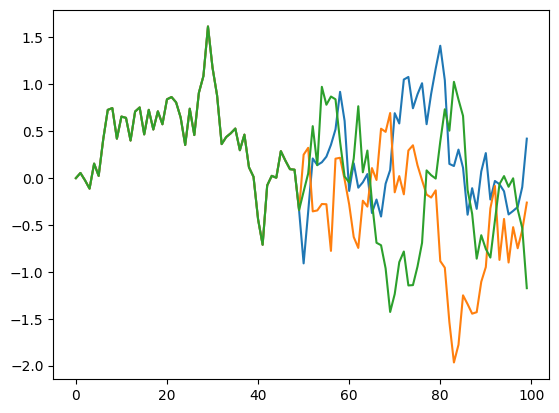

In [36]:
plt.plot(X_ou_test[0])
for i in range(0, 2):
    plt.plot(predict['imputation'][0][i])

Text(0.5, 0, 'Значение отклонения')

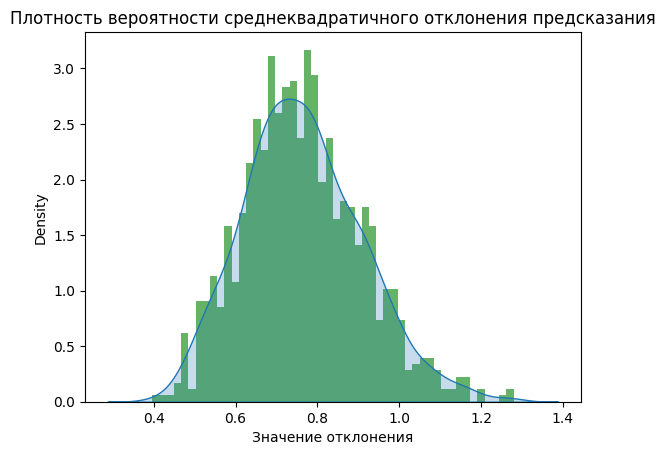

In [37]:
std_dev = [standart_deviation(predict['imputation'][0,i, missing_start:, 0], X_ou_test[0, missing_start:, 0]) for i in range(n_sampling_times)]

plt.hist(std_dev, bins = 50, density = True, alpha = 0.6, color = 'g')

sns.kdeplot(std_dev, fill = True)

plt.title("Плотность вероятности среднеквадратичного отклонения предсказания")
plt.xlabel("Значение отклонения")

Орнштейн-Уленбеков:

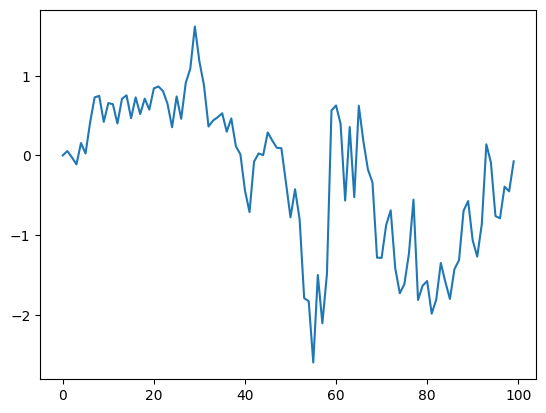

In [38]:
#X_ou_test = generate_ou_process(n_test_samples, n_steps, mu=0, theta=0.15, sigma=0.3)
data_missing = {"X": X_ou_test_missing}
inject_ou_anomaly(X_ou_test, missing_start, missing_start + missing_rate - 1, mu=0, theta=0.3, sigma=0.6)

plt.plot(X_ou_test[0])

n_sampling_times = 1000 #количество сэмлов 
#predict = model.predict(data_missing, n_sampling_times=n_sampling_times)

Text(0.5, 0, 'Значение отклонения')

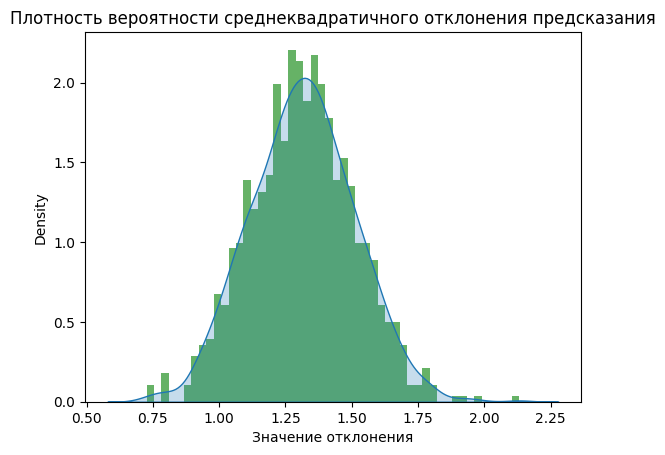

In [39]:
std_dev = [standart_deviation(predict['imputation'][0,i, missing_start:, 0], X_ou_test[0, missing_start:, 0]) for i in range(n_sampling_times)]

plt.hist(std_dev, bins = 50, density = True, alpha = 0.6, color = 'g')

sns.kdeplot(std_dev, fill = True)

plt.title("Плотность вероятности среднеквадратичного отклонения предсказания")
plt.xlabel("Значение отклонения")

СИНУС:

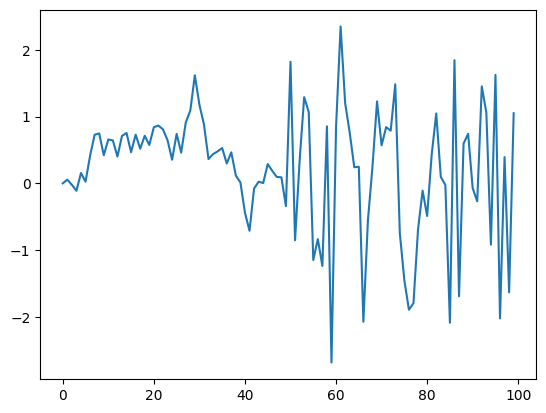

In [40]:
#X_ou_test = generate_ou_process(n_test_samples, n_steps, mu=0, theta=0.15, sigma=0.3)
data_missing = {"X": X_ou_test_missing}
inject_sin_anomaly(X_ou_test, missing_start, missing_start + missing_rate - 1, periods=5, noise_rate=1)

plt.plot(X_ou_test[0])

n_sampling_times = 1000 #количество сэмлов 
#predict = model.predict(data_missing, n_sampling_times=n_sampling_times)

Text(0.5, 0, 'Значение отклонения')

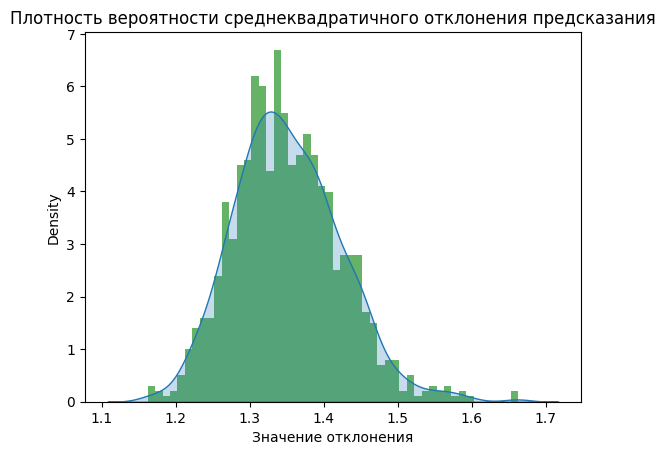

In [41]:
std_dev = [standart_deviation(predict['imputation'][0,i, missing_start:, 0], X_ou_test[0, missing_start:, 0]) for i in range(n_sampling_times)]

plt.hist(std_dev, bins = 50, density = True, alpha = 0.6, color = 'g')

sns.kdeplot(std_dev, fill = True)

plt.title("Плотность вероятности среднеквадратичного отклонения предсказания")
plt.xlabel("Значение отклонения")

In [92]:
crps_treshold = 0.5 #compute_crps_percentile(X_ou_train, missing_rate)
n_features=1

print(crps_treshold)
print()
anomalies = 0
for sample in range(0, n_test_samples):
    n_segments = n_steps // missing_rate
    true_segments = X_ou_test[sample, :, :].reshape(-1, missing_rate, n_features)
    pred_segments = predict['imputation'][sample].reshape(n_segments, n_sampling_times, missing_rate, n_features)

    has_anomaly = False
    anomaly_start = -1
    for seg in range(0, len(true_segments)) :
        print(true_segments[seg].shape)
        print(pred_segments[seg].shape)
        crps_sum = 0
        for f in range(0, n_features):
            crps = 0
            for i in range(0, n_sampling_times) :
                crps += crps_ensemble(true_segments[seg][:][f], pred_segments[seg][i][:][f])
            crps /= n_sampling_times
            crps_sum += crps
        seg_crps = crps_sum / n_features
        if seg_crps > crps_treshold :
            has_anomaly = True
            anomaly_start = i * missing_rate
            break
    
    if (has_anomaly) :
        anomalies += 1
print(anomalies)
    


0.5

(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
(100, 10, 1)
(10, 1)
